# Modelado de los Datos
A lo largo de este notebook se cubre la cuarta fase de la metodología CRIPS-DM, en este caso el modelado del conjunto de datos. En este notebook se incluye el modelado mediante el modelo

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. **Preparación de los Datos (Data Preparation)**
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**</span>
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico. En este caso se incluye el modelo más basico que se tomará como baseline, en este caso UNET

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.



Con los datos seleccionados del conjunto de datos, pasamos a generar nuevos datos adicionales que nos permitan entrenar el modelo con una cuantia de datos aun mayor dadas las clases seleccionadas, además de extraer nuevas características de nuestras imágemes para obtener mejores resultados con los modelos a usar. Es por ello que este apartado se divide en dos etapas:

1. Muestreado y ajuste de las imágenes

2. Generación de imágenes derivadas de las actuales

3. Uso de modelos fundacionales

### 1. Sampleado del conjunto de datos

Este primer apartado abarca la corrección de aquellas deficiencias enconrtadas a lo largo del notebook anterior, relativo al análisis exploratorio de los datos.

A lo largo de esta primera parte del noteobook se procederá a la realización del sampleo de instancias del dataset inicial, dando como salida en este caso un dataset nativo de tensorflow `tf.dataset`, que permitirá que el entrenamierto del modelo sea lo más rápido posible. Los objetivos de este apartado serán varios:

- La eliminación las máscaras demasiado pequeñas, para facilitar el aprendijaze del modelo

- La obtención de  un conjunto de entrenamieto mucho más balanceado

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 22.1 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import os

import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
import matplotlib.patches as mpatches
from tensorflow.keras import layers, models
#from utils import  load_yaml_file

from tqdm import tqdm
from pycocotools.coco import COCO
import time

from sklearn.metrics import average_precision_score


from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers, models

from google.colab import drive

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

import keras
from keras.saving import register_keras_serializable

# Para plotting del modelo
from tensorflow.keras.utils import plot_model

import visualkeras
#visualkeras.layered_view(model, legend=True).show()
from PIL import ImageFont
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


In [ ]:
yaml = {
    "dirs": {
        "anotaciones": {
            "train": "./dataset/coco/annotations/instances_train2017.json",
            "test": "./dataset/coco/annotations/instances_test2017.json",
            "val": "./dataset/coco/annotations/instances_val2017.json"
        },
        "imagenes": {
            "train": "./dataset/coco/train2017/",
            "test": "./dataset/coco/test2017/",
            "val": "./dataset/coco/val2017/"
        },
        "models": {
            "fastSAM": "./models/FastSAM-x.pt"
        }
    },
    "objetive_classes": [
        "person",
        "car",
        "motorcycle",
        "bus",
        "traffic light",
        "backpack",
        "handbag",
        "cell phone",
        "chair",
        "dining table"
    ],
    "size_sample": 30
}


category_info_objetive = {1: 'person',
 3: 'car',
 4: 'motorcycle',
 6: 'bus',
 10: 'traffic light',
 27: 'backpack',
 31: 'handbag',
 77: 'cell phone',
 62: 'chair',
 67: 'dining table',
 0: 'background'}

Se carga toda la info necesaria del conjunto de datos:

In [ ]:
#yaml = load_yaml_file()

objetives = yaml["objetive_classes"]
N =10000# yaml["size_sample"]
N_CLASSES = len(objetives) + 1

En este caso dado que el entrenamiento se ha realizado en google drive se realiza la carga de los ficheros del mismo

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tfrecord_path_train = r"/content/drive/MyDrive/TFM/dataset_train.tfrecord"
tfrecord_path_test = r"/content/drive/MyDrive/TFM/dataset_test.tfrecord"

batch_size = 16
N_CLASSES = 11



In [ ]:
def parse_tfrecord(example_proto):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "mask_shape": tf.io.FixedLenFeature([2], tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)

    img = tf.io.decode_jpeg(example["image"])
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = example["mask_shape"]
    mask = tf.io.decode_raw(example["mask"], tf.uint8)
    mask = tf.reshape(mask, shape)
    mask = tf.one_hot(mask, depth=N_CLASSES)

    return img, mask





In [ ]:
def augment_data(image,mask):

    ### Flipeo aleatorio de la imagen
    if tf.random.uniform(()) > 0.85:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    ### Rotacion uniforme de la imagen
    if tf.random.uniform(()) > 0.95:
        k = tf.random.uniform(minval=0,maxval=4,dtype=tf.int32,shape=[])
        image = tf.image.rot90(image,k)
        mask = tf.image.rot90(mask,k)

    ### Ajuste en el brillo de la imagen
    if tf.random.uniform(()) > 0.85:
        image = tf.image.adjust_brightness(image, delta=tf.random.uniform([], -0.1, 0.1))


    ### Aplicacion de cambios en el contraste de la imagen
    if tf.random.uniform(()) > 0.85:
        image = tf.image.adjust_contrast(image, contrast_factor=tf.random.uniform([], 0.9, 1.1))

    ### Aplicacion de ruido gaussiano
    if tf.random.uniform(()) > 0:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # # Zooming aleatorio de la imagen
    # if tf.random.uniform(()) > 0.95:
    #     scale = tf.random.uniform([], 0.8, 1.2)
    #     original_size = tf.shape(image)[:2]
    #     new_size = tf.cast(tf.cast(original_size, tf.float32) * scale, tf.int32)
    #     image = tf.image.resize(image, new_size)
    #     mask = tf.image.resize(mask, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #     image = tf.image.resize_with_crop_or_pad(image, tf.shape(image)[0], tf.shape(image)[1])
    #     mask = tf.image.resize_with_crop_or_pad(mask, tf.shape(mask)[0], tf.shape(mask)[1])

    return image,mask

In [ ]:
def carga_dataset(tfrecord_path,batch_size=32,size_mezcla=100,training=True):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = raw_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(size_mezcla)
        dataset = dataset.repeat()

    #dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset



# Load dataset
train_ds = carga_dataset(tfrecord_path_train, batch_size=16)

# Example: loop through a batch
for img_batch, mask_batch in train_ds.take(1):
    print("Image batch shape:", img_batch.shape)
    print("Mask batch shape:", mask_batch.shape)

Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 11)


In [ ]:
def plot_image_and_mask(image, mask):
    class_id_to_name = {i:category_info_objetive[key] for i, key in enumerate(sorted(category_info_objetive.keys()))}

    mask = np.argmax(mask, axis=2)
    class_ids = sorted([cid for cid in np.unique(mask)])

    # Uso de templates de colores predefinidas en matplot para que exista mas contraste entre clases de ids adyacentes, usando tab10
    colors = plt.cm.get_cmap('tab10',len(class_id_to_name))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Imagen")
    ax[0].axis("off")

    # Se incializa la mascara como todo fondo, y se itera añadiendo
    mask_colored = np.zeros((mask.shape[0],mask.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_colored[mask==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    # print(mask_colored)
    ax[1].imshow(mask_colored)
    ax[1].set_title("Máscara")
    ax[1].axis("off")

    # generación de la leyenda
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [ ]:
mask_batch.shape

TensorShape([16, 256, 256, 11])

/tmp/ipython-input-10-4257581388.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


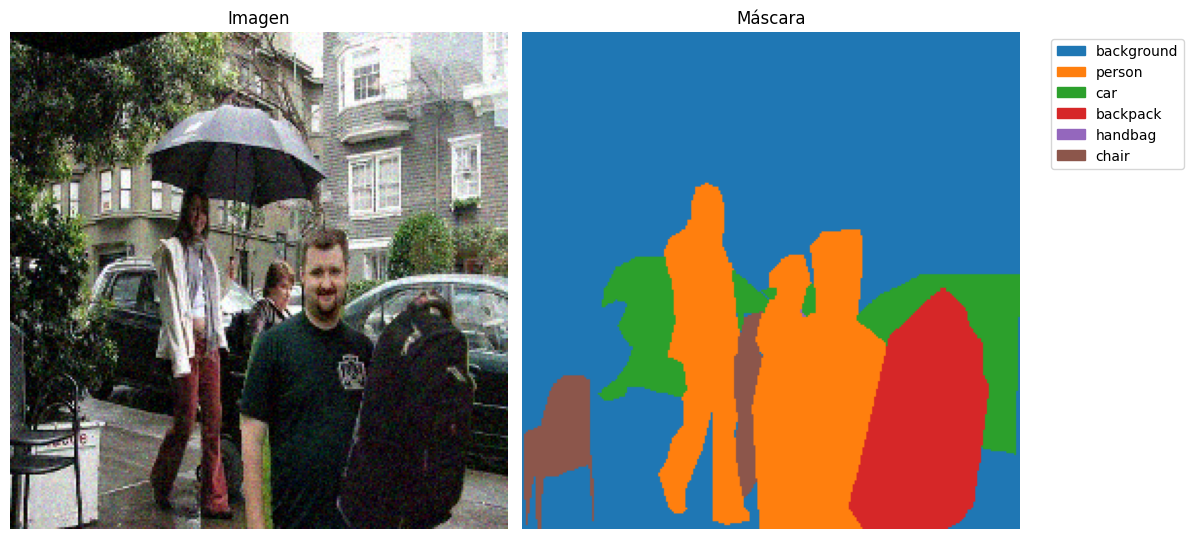

In [ ]:
plot_image_and_mask(img_batch[3,...], mask_batch[3,...])

In [ ]:
class IoULoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, ignore_index=0, eps=1e-6, name="iou_loss"):
        super().__init__(name=name)
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.eps = eps

    def call(self, y_true, y_pred):
        # y_pred debe estar ya con softmax aplicado (o ser la salida del modelo con activation='softmax')
        probs = tf.clip_by_value(y_pred, self.eps, 1. - self.eps)

        ious = []
        for c in range(self.num_classes):
            if c == self.ignore_index:
                continue
            pred = probs[..., c]
            true = y_true[..., c]

            intersection = tf.reduce_sum(pred * true, axis=[1, 2])
            union = tf.reduce_sum(pred + true, axis=[1, 2]) - intersection

            iou = (intersection + self.eps) / (union + self.eps)
            ious.append(iou)

        iou = tf.reduce_mean(tf.stack(ious, axis=0), axis=0)
        return 1. - tf.reduce_mean(iou)


In [ ]:
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.ce = tf.keras.losses.CategoricalCrossentropy()
        self.iou = IoULoss(num_classes=11, ignore_index=-1)

    def call(self, y_true, y_pred):
        return self.alpha * self.ce(y_true, y_pred) + (1 - self.alpha) * self.iou(y_true, y_pred)


In [ ]:

def unet_light(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Downsampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Upsampling
    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(c5)


    return models.Model(inputs=inputs, outputs=outputs)


In [ ]:

# Tamaño del input al que hemos adaptado el dataset
input_shape = (256, 256, 3)

# Declaración del modelo
model = unet_light(input_shape=input_shape, num_classes=N_CLASSES)

# Plotting de capas y parámetros
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_44[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_46[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_48[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 128, 128,  │     32,832 │ conv2d_49[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 128, 128,  │     73,792 │ concatenate_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_50[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 256, 256,  │      8,224 │ conv2d_51[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 256, 256,  │     18,464 │ concatenate_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_52[0][0] 

 Total params: 466,859 (1.78 MB)

 Trainable params: 466,859 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

TODO

In [ ]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=initial_learning_rate)


En este caso dado que el coste de realizar el entrenamiento y del cálculo de métricas es alto y el uso de la GPU de Google es limitada, cortandose en los entrenamientos, se desplaza el cálculo de métricas a fases posteriores. Es por ello que en primera instancia nos limitamos a entrenar el modelo calculando únicamente la `accuracy` del modelo, y, una vez guardado como `.keras` se procederá al cálculo de métricas más avanzadas.

In [ ]:

# Priemra prueba para el entrenamiento más rapido posible
#model.compile(optimizer='adam', loss=BCEIoULoss(num_classes=len(category_info_objetive), ignore_index=0), metrics=['accuracy'])
model.compile(
    optimizer=optimizer,
    loss=CombinedLoss(alpha=0.6),  # más peso a la crossentropy al inicio
    metrics=['accuracy']
)


# Callbacks para ir almacenando resultados, modificar el LR de forma dinámica parad hacer que el entrenamiento converja y frenar el entrenamiento del modelo cuando no se produzca aprendizaje
callbacks = [
    ModelCheckpoint(r"/content/drive/MyDrive/TFM/third_model.keras", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    CSVLogger(r"/content/drive/MyDrive/TFM/training_log_UNET.csv")
]



Carga del `tfrecord` en memoria tanto del train como del test

In [ ]:
train_dataset = carga_dataset(tfrecord_path_train, batch_size=16)
test_dataset = carga_dataset(tfrecord_path_test, batch_size=16)

Se realiza el entrenamiento, usando verbose para la inclusión de la mayor info en el mismo. Asimismo se hace

In [ ]:
history = model.fit(
    train_dataset.repeat(),
    steps_per_epoch=3000,
    validation_data=test_dataset,
    epochs=50,
    validation_steps=100,
    callbacks= callbacks,
    verbose=1
)


Epoch 1/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 663s 217ms/step - accuracy: 0.6169 - loss: 1.1292 - val_accuracy: 0.6483 - val_loss: 1.0105 - learning_rate: 0.0010
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 656s 219ms/step - accuracy: 0.6466 - loss: 1.0145 - val_accuracy: 0.6678 - val_loss: 0.9664 - learning_rate: 0.0010
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 682s 227ms/step - accuracy: 0.6654 - loss: 0.9781 - val_accuracy: 0.6748 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 653s 218ms/step - accuracy: 0.6754 - loss: 0.9583 - val_accuracy: 0.6761 - val_loss: 0.9545 - learning_rate: 0.0010
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 655s 218ms/step - accuracy: 0.6773 - loss: 0.9522 - val_accuracy: 0.6925 - val_loss: 0.9246 - learning_rate: 0.0010
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 682s 227ms/step - accuracy: 0.6869 - loss: 0.9366 - val_accuracy: 0.6963 - val_loss: 0.9176 - learning_rate: 0.0010
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 655s 218ms

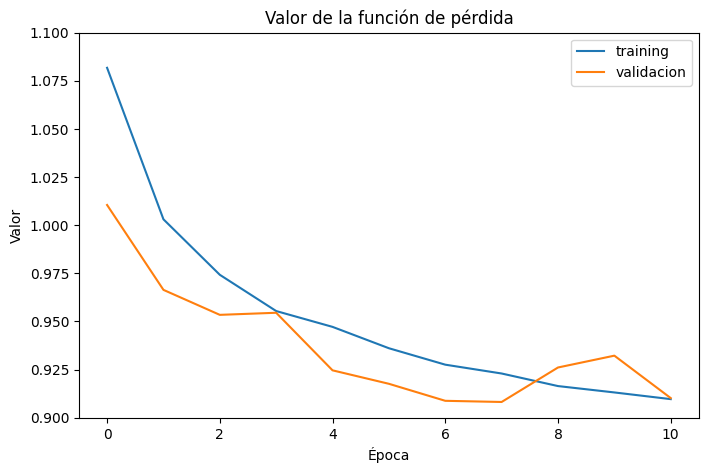

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = "/content/drive/MyDrive/TFM/training_log_UNET.csv"
log_df = pd.read_csv(log_path)

history = {col: log_df[col].values for col in log_df.columns if col != 'epoch'}

# === Plot Training and Validation Loss ===
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label='training')
plt.plot(history['val_loss'], label='validacion')
plt.title('Valor de la función de pérdida')
plt.ylabel('Valor')
plt.xlabel('Época')
plt.legend(loc='upper right')
plt.grid(False)
plt.ylim([0.9, 1.1])  # <-- Set y-axis limits here
plt.show()

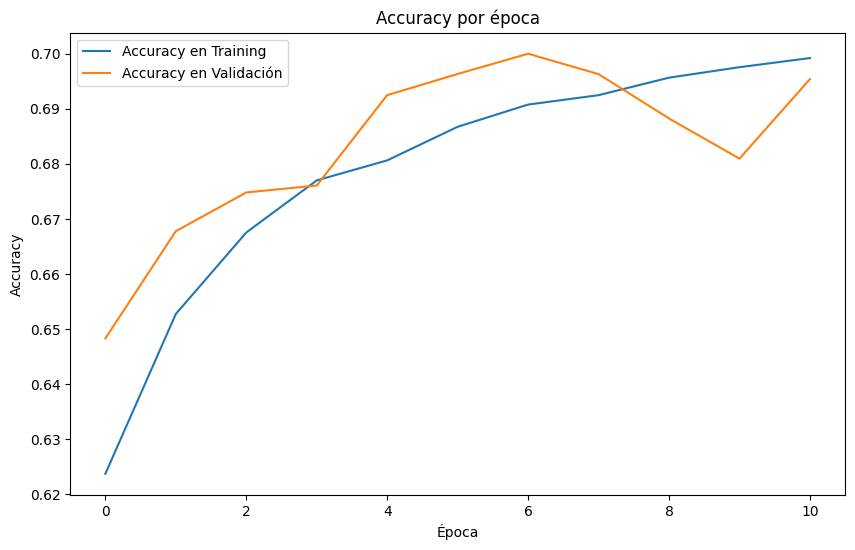

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(log_data['epoch'], log_data['accuracy'], label='Accuracy en Training')
plt.plot(log_data['epoch'], log_data['val_accuracy'], label= 'Accuracy en Validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Accuracy por época')
plt.legend()
plt.grid(False)
plt.show()

## 2. Testeo y generación de métricas


Testeo de la inferencia

A continuación, se prueban las salidas del modelo en algunas de las imágenes del test. Se carga el modelo desde el path donde ha sido almacenado dado que el entrenamiento y la evaluación se han realizado en diferentes sesiones.

In [ ]:
model = keras.models.load_model(r"/content/drive/MyDrive/TFM/third_model.keras", custom_objects={'IoULoss': IoULoss})
#model = keras.models.load_model(r"/content/drive/MyDrive/TFM/second_model.keras")

In [ ]:
for x_batch, y_batch in train_ds.take(1):
    predictions = model.predict(x_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


In [ ]:
def plot_image_and_mask_and_gt(image, mask, gt):
    class_id_to_name = {i:category_info_objetive[key] for i, key in enumerate(sorted(category_info_objetive.keys()))}

    mask = np.argmax(mask, axis=2)
    class_ids = sorted([cid for cid in np.unique(list(np.unique(mask))+ list(np.unique(gt)))])

    # Uso de templates de colores predefinidas en matplot para que exista mas contraste entre clases de ids adyacentes, usando tab10
    colors = plt.cm.get_cmap('tab10',len(class_id_to_name))

    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Imagen")
    ax[0].axis("off")

    # Se incializa la mascara como todo fondo, y se itera añadiendo
    mask_colored = np.zeros((mask.shape[0],mask.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_colored[mask==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    # print(mask_colored)
    ax[1].imshow(mask_colored)
    ax[1].set_title("Ground Truth")
    ax[1].axis("off")

    # generación de la leyenda
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    mask_gt_colored = np.zeros((gt.shape[0],gt.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_gt_colored[gt==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    ax[2].imshow(mask_gt_colored)
    ax[2].set_title("Predicción U-Net")
    ax[2].axis("off")

    # generación de la leyenda
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


/tmp/ipython-input-56-1745276833.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


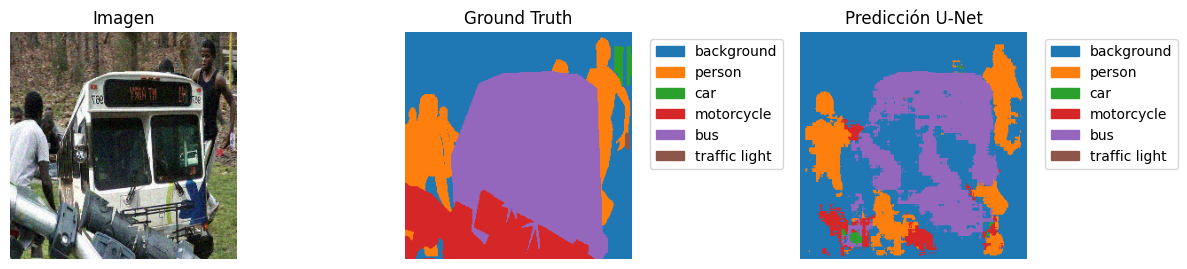

In [ ]:
for x_batch, y_batch in train_ds.take(1):
    predictions = model.predict(x_batch)
    final_prediction = np.argmax(predictions[0,...], axis=-1)
    plot_image_and_mask_and_gt(image = x_batch[0,...] , mask = y_batch[0,...],gt =  final_prediction)

In [ ]:
for x_batch, y_batch in train_ds.take(1):
    predictions = model.predict(x_batch)
    final_prediction = np.argmax(predictions[0,...], axis=-1)
    plot_image_and_mask_and_gt(image = x_batch[0,...] , mask = y_batch[0,...],gt =  final_prediction)

NameError: name 'train_ds' is not defined

### 2. Cáculo de métricas

Se calculan el conjunto de métricas que serán usadas a posteriori para evaluar el funcionamiento del mismo y realizar una comparativa entre los modelos entrenados.

Mediante las funciones de `utils` se imprimen comparativas de los resultados frente al ground truth

In [ ]:
def compute_iou(pred_mask, true_mask) -> float:


    ious = []
    num_classes = pred_mask.shape[0]

    for c in range(num_classes):
        pred = pred_mask[c]
        truth = true_mask[c]

        if  truth.any():

            intersection = np.logical_and(pred, truth).sum()
            union = np.logical_or(pred, truth).sum()

            iou = intersection / union if union != 0 else 0.0
            ious.append(iou)

            # print("For class ", c, " has value ", iou)



    return np.mean(ious)

In [ ]:
def mean_pixel_accuracy(pred_mask, true_mask) -> float:


    class_accuracies = []

    for c in range(pred_mask.shape[0]):
        pred = pred_mask[c]
        truth = true_mask[c]

        total_true = truth.sum()
        if total_true != 0:

            correct = np.logical_and(pred, truth).sum()
            acc = correct / total_true
            class_accuracies.append(acc)

            # print("For class ", c, " has value ", acc)

    return np.mean(class_accuracies)


In [ ]:


def mean_average_precision(prob_mask, true_mask) -> float:

    C, H, W = true_mask.shape
    aps = []

    for c in range(C):
        y_true = true_mask[c].ravel().astype(int)
        y_score = prob_mask[c].ravel()

        if y_true.sum() != 0:
            ap = average_precision_score(y_true, y_score)
            aps.append(ap)

            # print("for ", c, " has value ",ap)


    return np.mean(aps)

In [ ]:
def get_value_metrics(prob_mask, ground_truth) -> tuple[float, float, float ]:

    # result = mean_pixel_accuracy(mask_one_hot_pred, mask_one_hot_gt)
    mean_pixel_acc = mean_pixel_accuracy(prob_mask, ground_truth)

    # result = compute_iou(mask_one_hot_pred, mask_one_hot_gt)

    iou = compute_iou(prob_mask, ground_truth)

    # mean_average_precision(one_hot_scores[0],mask_one_hot_gt )
    mean_av_pre = mean_average_precision(prob_mask, ground_truth)

    return mean_pixel_acc, iou, mean_av_pre


In [ ]:

n_samples_batches = 2

In [ ]:

list_mean_pixel_acc = []
list_iou = []
list_mean_av_prec = []
list_inference_time = []

ids_under_threshold = []
ids_over_threshold = []

for i, (img_batch, mask_batch) in enumerate(train_ds.take(n_samples_batches)):
  print("getting inference over batch ", i)
  comienzo_inferencia = time.time()
  predictions = model.predict(img_batch)
  fin_inferencia = time.time()
  try:

    for target_index in img_batch.shape[0]:

      image, mask_gt = img_batch[target_index,...], mask_batch[target_index,...]
      mask_gt = np.argmax(mask_gt, axis=-1)

      prediction_image = np.argmax(predictions[target_index,...], axis=-1)

      mean_pixel_acc, iou, mean_av_pre = get_value_metrics(prediction_image, mask_gt)
      #print("metrics are ", mean_pixel_acc, iou, mean_av_pre)


      list_mean_pixel_acc.append(mean_pixel_acc)
      list_iou.append(iou)
      list_mean_av_prec.append(mean_av_pre)
      list_inference_time.append(round((fin_inferencia -comienzo_inferencia)/img_batch.shape[0], 2) )

      if(mean_pixel_acc> 0.95):
        ids_over_threshold.append((i, target_index))

      elif(iou<0.5):
        ids_under_threshold.append((i, target_index))

  except Exception as e:
    print("Exception ", e , " at it ", i)

for i, (img_batch, mask_batch) in enumerate(train_ds.take(n_samples_batches)):

  print("getting inference over batch ", i)


Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 11)
Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 11)
